In [1]:
# Add project's path to system path
import os
import sys
try: 
    proj_path
except NameError:
    os.chdir('../')
    proj_path = os.getcwd()
    if proj_path not in sys.path:
        sys.path.append(proj_path)

# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx
from scipy import linalg

from codebase import utils, rewiring, rewiring_iterations, directed_modularity # custom-made functions

In [42]:
def convert_from_adj2networkX(A,weight_d='binary'):

    edges_ind = np.where(A>0)
    num_edges = len(edges_ind[0])

    G = nx.DiGraph()   # DiGraph
    G.add_nodes_from(np.arange(A.shape[0]))

    edges_list = list()
    if weight_d == 'binary':
        for ind in np.arange(num_edges):
            edge_pair = (edges_ind[1][ind],edges_ind[0][ind])
            edges_list.append(edge_pair)
        
        G.add_edges_from(edges_list)    
    else:
        for ind in np.arange(num_edges):
            edge_pair_w = (edges_ind[1][ind],edges_ind[0][ind],A[edges_ind[0][ind],edges_ind[1][ind]])
            edges_list.append(edge_pair_w)    
        
        G.add_weighted_edges_from(edges_list)
        
        
    return G

In [29]:
def getDigraphPathMetricsForHubs(Ax,inOutThresh = 10):

    inDeg = np.sum(Ax,axis=1)
    outDeg = np.sum(Ax,axis=0)
    
    #thresh = inOutThresh
    #numHubs = len(np.where(inDeg>=thresh)[0]) + len(np.where(outDeg>=thresh)[0])
    #ttt = 'num of hubs are '+str(numHubs)
    #print(ttt)
    
    #numHubs2 = len(np.union1d(np.where(inDeg>=thresh)[0],np.where(outDeg>=thresh)[0]))
    #ttt = 'num of hubs2 are '+str(numHubs2)
    #print(ttt)
    
    #bare minimum nodes should have greater than 1 in and out-degrees
    nonZeroIn = np.where(inDeg>1)[0]
    nonZeroOut = np.where(outDeg>1)[0]
    nonZeroInOut = np.intersect1d(nonZeroIn,nonZeroOut)

    inOutDeg = inDeg + outDeg
    #indNodes2Use = np.where(inOutDeg>=inOutThresh)[0]
    indNodesTemp = np.where(inOutDeg>=inOutThresh)[0]
    indNodes2Use = np.intersect1d(nonZeroInOut,indNodesTemp)
    lenNodes2Use = len(indNodes2Use)
    
    
    G = convert_from_adj2networkX(Ax)

    paths = dict(nx.all_pairs_dijkstra_path(G))
    len_paths = dict(nx.all_pairs_dijkstra_path_length(G))


    # it is opposite from the adjacency matrix, i.e. pathsMatrix[i,j] is path length from i to j
    pathsMatrix = np.zeros((lenNodes2Use,lenNodes2Use)) 
    for indSource,source in enumerate(indNodes2Use):
        for target in len_paths[source].keys():
            if target in indNodes2Use:
            
                indTarget = np.where(indNodes2Use == target)[0][0]
                pathsMatrix[indSource, indTarget] = len_paths[source][target]

    numPaths = np.sum(pathsMatrix>0)
    numNonPaths = lenNodes2Use*(lenNodes2Use-1) -numPaths 
    distPaths = pathsMatrix[np.where(pathsMatrix>0)]
    
    return indNodes2Use, numPaths,numNonPaths,distPaths,pathsMatrix

In [3]:
def getDigraphPathMetrics(Ax):

    G = convert_from_adj2networkX(Ax)
    nodes = len(G.nodes)

    paths = dict(nx.all_pairs_dijkstra_path(G))
    len_paths = dict(nx.all_pairs_dijkstra_path_length(G))

    # it is opposite from the adjacency matrix, i.e. pathsMatrix[i,j] is path length from i to j
    pathsMatrix = np.zeros((nodes,nodes)) 
    for source in np.arange(nodes):
        for target in len_paths[source].keys():
            pathsMatrix[source, target] = len_paths[source][target]

    numPaths = np.sum(pathsMatrix>0)
    numNonPaths = nodes*(nodes-1) -(numPaths + nodes)
    distPaths = pathsMatrix[np.where(pathsMatrix>0)] 
    
    invDistPaths = 1.0/distPaths
    avInvPathAll = np.sum(invDistPaths)/(nodes*(nodes-1))
    avPathAll = (1.0/avInvPathAll)
    avInvPathOnlyPaths = np.sum(invDistPaths)/numPaths
    avPathOnlyPaths = (1.0/avInvPathOnlyPaths)

    return numPaths,numNonPaths,distPaths,pathsMatrix,avPathAll,avPathOnlyPaths

## Find the connectivity metrics of the subset of nodes with high in or out degrees

In [130]:
directory_load = 'data/'

flag = '_cons_adv_50_'

file_path_load = directory_load +'A'+flag+'pRand.pckl'
A = utils.load_var(file_path_load)

pRandVec = [0,0.2,0.4,0.6,0.8]
repetitions = 100
numNodes = 100

In [131]:
inOutThresh = 30

pathUnitDict = {}
pathSimpleDict={}
for rep in np.arange(repetitions):
    for indP,p in enumerate(pRandVec):
        
        Ax = A[rep+1][p,1][4000]
        indNodesUnit,numPaths,numNonPaths,distPaths,pathsMatrix = getDigraphPathMetricsForHubs(Ax,inOutThresh)

        if len(indNodesUnit)>0:
            AUnit = Ax[indNodesUnit[:, None], indNodesUnit]
            numPaths,numNonPaths,distPaths,pathsMatrix,avPathAll,avPathOnlyPaths = getDigraphPathMetrics(AUnit)
            pathUnitDict[rep+1,p,flag] = (AUnit,numPaths,numNonPaths,distPaths,pathsMatrix)
        
            #put here random nodes the size of Asubset to compare
            indSimpleNodes = np.setdiff1d(np.arange(numNodes), indNodesUnit, assume_unique=False)
            if len(indNodesUnit) < len(indSimpleNodes):
                indRandSimpleNodes = random.sample(list(indSimpleNodes),len(indNodesUnit))
            else:
                indRandSimpleNodes = indSimpleNodes
            
            indRandSimpleNodes = np.array(indRandSimpleNodes)

            ASimple = Ax[indRandSimpleNodes[:, None], indRandSimpleNodes]
            numPathsSimple,numNonPathsSimple,distPathsSimple,pathsMatrixSimple,avPathAllSimple,avPathOnlyPathsSimple = getDigraphPathMetrics(ASimple)
            pathSimpleDict[rep+1,p,flag] = (ASimple,numPathsSimple,numNonPathsSimple,distPathsSimple,pathsMatrixSimple)
        else:
            pathUnitDict[rep+1,p,flag] = pathUnitDict[rep,p,flag]
            pathSimpleDict[rep+1,p,flag] = pathSimpleDict[rep,p,flag]
            

(14,)
(14,)
(11,)
(9,)
(4,)
(13,)
(14,)
(12,)
(9,)
(7,)
(15,)
(13,)
(13,)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


(10,)
(4,)
(15,)
(14,)
(9,)
(8,)
(7,)
(13,)
(18,)
(14,)
(8,)
(6,)
(14,)
(17,)
(12,)
(8,)
(4,)
(15,)
(16,)
(11,)
(9,)
(4,)
(15,)
(17,)
(17,)
(8,)
(2,)
(15,)
(14,)
(13,)
(10,)
(3,)
(14,)
(17,)
(16,)
(9,)
(5,)
(13,)
(19,)
(14,)
(6,)
(6,)
(15,)
(18,)
(13,)
(9,)
(5,)
(14,)
(17,)
(12,)
(11,)
(4,)
(14,)
(17,)
(12,)
(5,)
(4,)
(13,)
(13,)
(15,)
(8,)
(3,)
(13,)
(16,)
(12,)
(10,)
(4,)
(14,)
(18,)
(13,)
(7,)
(4,)
(14,)
(17,)
(12,)
(9,)
(4,)
(13,)
(14,)
(12,)
(6,)
(5,)
(15,)
(15,)
(13,)
(10,)
(4,)
(15,)
(18,)
(11,)
(9,)
(5,)
(15,)
(20,)
(13,)
(8,)
(5,)
(15,)
(16,)
(13,)
(8,)
(3,)
(14,)
(13,)
(11,)
(7,)
(5,)
(14,)
(15,)
(11,)
(8,)
(6,)
(14,)
(17,)
(12,)
(6,)
(5,)
(14,)
(20,)
(16,)
(9,)
(4,)
(13,)
(15,)
(10,)
(9,)
(5,)
(14,)
(19,)
(11,)
(9,)
(4,)
(14,)
(15,)
(11,)
(7,)
(4,)
(13,)
(14,)
(14,)
(10,)
(6,)
(15,)
(19,)
(14,)
(7,)
(4,)
(14,)
(16,)
(13,)
(9,)
(2,)
(13,)
(18,)
(16,)
(8,)
(5,)
(15,)
(15,)
(12,)
(10,)
(4,)
(14,)
(17,)
(13,)
(7,)
(5,)
(14,)
(16,)
(13,)
(9,)
(3,)
(13,)
(16,)
(13,)
(10,)
(4,)
(13

In [132]:
pR=[0,0.2,0.4,0.6]

nodesUnit = {}; nodesSimple = {}; connectionsUnit = {}; connectionsSimple = {}
densityUnit = {}; densitySimple = {}
for p in pR:
    nodesUnit[p]= np.zeros((repetitions,1)); nodesSimple[p] = np.zeros((repetitions,1))
    connectionsUnit[p] = np.zeros((repetitions,1));connectionsSimple[p] = np.zeros((repetitions,1))
    for rep in np.arange(repetitions):
    
        (AUnit,numPaths,numNonPaths,distPaths,pathsMatrix)=pathUnitDict[rep+1,p,flag]        
        nodesUnit[p][rep] = AUnit.shape[0]
        connectionsUnit[p][rep] = np.sum(AUnit)
        
        (ASimple,numPathsSimple,numNonPathsSimple,distPathsSimple,pathsMatrixSimple)=pathSimpleDict[rep+1,p,flag]        
        nodesSimple[p][rep] = ASimple.shape[0]
        connectionsSimple[p][rep] = np.sum(ASimple)

        
    densityUnit[p] = connectionsUnit[p]/(nodesUnit[p]*(nodesUnit[p]-1))
    densitySimple[p] = connectionsSimple[p]/(nodesSimple[p]*(nodesSimple[p]-1))

    

In [121]:
np.mean(densityUnit[0.4])

0.18534655732732838

In [122]:
np.mean(densityUnit[0.6])/np.mean(densitySimple[0.6])

3.799266410291685

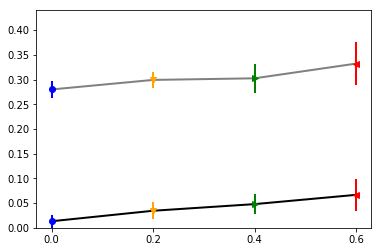

In [133]:
densityUnitMean = np.zeros((len(pR),1))
densityUnitStd = np.zeros((len(pR),1))

densitySimpleMean = np.zeros((len(pR),1))
densitySimpleStd = np.zeros((len(pR),1))


markers = ['o','v','>','<']
colors = ['blue','orange','green','red']

for ind,p in enumerate(pR):
    densityUnitMean[ind] = np.mean(densityUnit[p])
    densityUnitStd[ind] = np.std(densityUnit[p])
    
    densitySimpleMean[ind] = np.mean(densitySimple[p])
    densitySimpleStd[ind] = np.std(densitySimple[p])    
    

plt.plot(pR,densityUnitMean,color='grey',linewidth=2,label='Convergent-Divergent unit')
plt.plot(pR,densitySimpleMean,color='black',linewidth=2,label='Simple unit')
plt.xticks(pR)
plt.yticks([0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4])
plt.ylim([0,0.44])  
#plt.legend()
for ind in np.arange(len(densityUnitMean)):
    plt.errorbar(pR[ind],densityUnitMean[ind],densityUnitStd[ind],marker= markers[ind],color=colors[ind],linewidth=2)
    plt.errorbar(pR[ind],densitySimpleMean[ind],densitySimpleStd[ind],marker= markers[ind],color=colors[ind],linewidth=2)


filePathPlot = 'data/convdiv/Density'+str(inOutThresh)+'.eps'    

plt.savefig(filePathPlot, format='eps', dpi=1200)

[91, 46, 5, 35, 12, 79, 44, 51, 11, 25, 97, 42, 59, 85]

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]


array([[ 0,  2],
       [ 4,  6],
       [12, 14]])

[[ 0  2]
 [ 4  6]
 [12 14]]


(3,)

[29, 25, 41, 65, 91]